In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 180 (delta 80), reused 130 (delta 43), pack-reused 0
Receiving objects: 100% (180/180), 28.69 MiB | 7.14 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Processing ./dul_2021
  Preparing metadata (setup.py) ... done
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15115 sha256=c0475554294c667c7817be9f5f5140148c42f8a9221c4ea8a9d37d3b3c4ee995
  Stored in directory: /private/var/folders/vl/r6yn347n7q135d8zllgggmv80000gn/T/pip-ephem-wheel-cache-chbmms51/wheels/2e/9b/e5/0e217d51f20b9ec5ae9ceda6071848d9bad1f55cf6c3b01926
Successfully built dul-2021
  Attempting uninstall: dul-2021
    Found existing installation: dul-2021 0.1.0
    Uninstalling dul-2021-0.1.0:
      Successfully uninstalled dul-2021-0.1.0


In [2]:
from dul_2021.utils.hw3_utils import *
from dul_2021.utils.hw2_utils import *
import numpy as np
import math
import os
from scipy.optimize import bisect
from abc import abstractmethod
import torch
from torch.nn import functional as F
from torch.optim import Adam
from torch import nn
from torch.distributions import Normal, Uniform
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
from torch.nn import utils
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Question 1: Autoregressive Flows for Images

Adapt your PixelCNN implementation from Homework 2 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 2 1(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


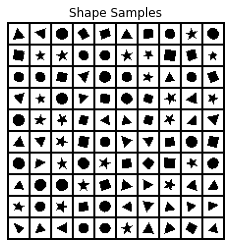

In [3]:
visualize_q1_data()

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [4]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = super().forward(x)
        return x.permute(0, 3, 1, 2)

In [5]:
class PixelConv2d_RGB(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.set_mask()
    
    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

In [6]:
class ConvA(PixelConv2d_RGB):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, : h // 2] = 1.
        self.mask[:, :, h // 2, : w // 2] = 1.

In [7]:
class ConvB(PixelConv2d_RGB):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, : h // 2] = 1.
        self.mask[:, :, h // 2, : w // 2 + 1] = 1.

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels, **kwargs):
        super().__init__()
        residual_size = num_channels // 2
        self.layers = nn.ModuleList([nn.ReLU(), 
                                     ConvB(num_channels, residual_size, 1, **kwargs),
                                     nn.ReLU(), 
                                     ConvB(residual_size, residual_size, kernel_size=7, padding=3, **kwargs),
                                     nn.ReLU(), 
                                     ConvB(residual_size, num_channels, 1, **kwargs)])
        
    def forward(self, x):
        y = x
        for layer in self.layers:
            y = layer(y)
        return x + y

In [9]:
class PixelCNN_RGB(nn.Module):
    def __init__(self, C, nc, num_filters=64, num_hidden_layers=3):
        super().__init__()
        self.C = C
        self.nc= nc
        layers = [ConvA(C, num_filters, 7, padding=3)] + \
                 [LayerNorm(num_filters), ResidualBlock(num_filters)] * num_hidden_layers + \
                 [LayerNorm(num_filters), nn.ReLU(), ConvB(num_filters, C * nc, 1)] 
        self.layers = nn.Sequential(*layers) # задаём сетку
        
    def forward(self, x): 
        x = x.float() / self.nc
        c, h, w = x.size()[1:]
        for layer in self.layers:
            x = layer(x)
        return x.view(- 1, self.nc, c, h, w)

In [10]:
class Flow(nn.Module):
    def __init__(self, dist, col=1, comp=5):
        super().__init__()
        self.comp = comp
        self.dist = dist
        self.pcnn = PixelCNN_RGB(col, comp * 3)
        
    def forward(self, x):
        x = self.pcnn(x)
        return x.chunk(3, 1)
    
    def flow(self, x):
        w, m, s = self(x)
        w = w.softmax(1)
        x = x[:, None].expand_as(w)
        distr = Normal(m, s.exp())
        return (w * distr.cdf(x)).sum(1), (w * distr.log_prob(x).exp()).sum(1).log() - math.log(2)
    
    def log_prob(self, x):
        z, d = self.flow(x)
        res = (self.dist.log_prob(z.clamp(0, 1)) + d)
        return res.mean((- 1, - 2))

In [11]:
def train(model, optimizer, dataset, lac):
    for batch in tqdm(dataset, desc='train', leave=False):
        b = batch.float().to(device)
        loss = - model.log_prob(0.5 * (b + torch.rand_like(b))).mean()
        lac.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()

In [12]:
def loss_evaluation(model, dataset):
    loss = 0.
    with torch.no_grad():
        for batch in tqdm(dataset, desc='test', leave=False):
            b = batch.float().to(device)
            loss -= model.log_prob(b).mean()
        loss /= len(dataset)
    return loss.item()

In [13]:
def training_epochs(model, train_dataset, test_dataset, epochs, lrate):
    train_loss = []
    test_loss = []
    optimizer = Adam(model.parameters(), lr=lrate)
    test_loss = [loss_evaluation(model, test_dataset)]
    for epoch in tqdm(range(epochs), desc='Epochs', leave=True):
        train(model, optimizer, train_dataset, train_loss)
        test_lo = loss_evaluation(model, test_dataset)
        test_loss.append(test_lo)
    return train_loss, test_loss

In [14]:
def inverse(d, comp, w, m, s):
    b = w.size(0)
    pixel_val = w.new_zeros(b)
    z = d.sample((b, ))
    with torch.no_grad():
        for i in range(b):
            dist = Normal(m[i], s[i].exp())
            def q(x):
                x = w.new_tensor(np.repeat(x, comp))
                return w[i].dot(dist.cdf(x)) - z[i]
            pixel_val[i] = bisect(q, - 20, 20)
    return pixel_val

In [15]:
def sample(model, n, inp):
    h, w, c = inp
    x = torch.zeros(n, c, h, w, device=device)
    with torch.no_grad():
        for i in range(inp[0]):
            for j in range(inp[1]):
                for k in range(inp[2]):
                    w, m, s = model(x)
                    w = w[:, :, k, i, j]
                    m = m[:, :, k, i, j]
                    s = s[:, :, k, i, j]
                    x[:, k, i, j] = inverse(model.dist, model.comp, w.softmax(1), m, s)
    return x.permute(0, 2, 3, 1).clamp(0., 1.).cpu().numpy()

In [16]:
def q1(train_data, test_data):
    '''
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
    '''
    d = Uniform(torch.tensor([0.]), torch.tensor([1.]))
    training_dataset = DataLoader(np.transpose(train_data, (0, 3, 1, 2)), batch_size=128, shuffle=True)
    test_data = (test_data + np.random.uniform(size=test_data.shape)) * 0.5
    testing_dataset = DataLoader(test_data.transpose(0, 3, 1, 2), batch_size=128, shuffle=False)
    model = Flow(d)
    train_loss, test_loss = training_epochs(model, training_dataset, testing_dataset, epochs=5, lrate=2e-3)
    sampling = sample(model, 100, train_data.shape[1:])
    return train_loss, test_loss, sampling

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results




Final Test Loss: 0.1913


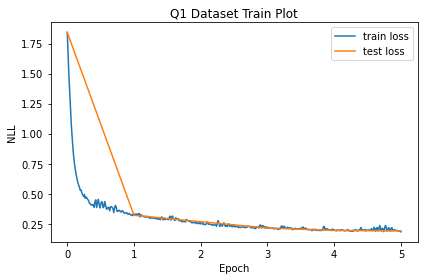

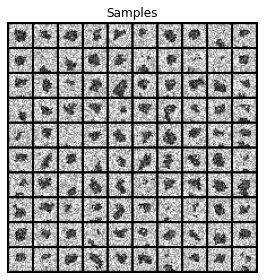

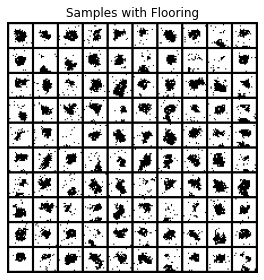

In [17]:
q1_save_results(q1) 
# поиграться с гиперпараметрами и должно быть получше: в первую очередь увеличить кол-во эпох